# About data_connector

This notebook pulls information from different sources of data (log, session) to connect student's data across types.
The end goal is a connection between student id and log files, survey data, and worksheet data.

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
import matplotlib.pyplot as plt
#utils.py is where all our custorm functions live is we set an autoreload on it.
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing 
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 20, 7
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)

## Overview
We have log data, survey data, worksheet data and lots of metadata. We have to connect them all! First we must build the right metadata files.
Let's start by connecting log data files to session data, mapping each log data to a student and to a session using dates and times.

## 1. Connecting log data to session data
We grab the parsing file reports and the session data

In [2]:
df_beers = get_latest_parsing_report('beers')
df_caps = get_latest_parsing_report('capacitor')
df_sessions = get_session_data()

Captured beers parsing report that was parsed on 2017-10-20_09.45.26
Captured capacitor parsing report that was parsed on 2017-10-20_10.06.46


In [3]:
df_sessions.head()

,session number,date,number of students from sign out sheet,start time,end time,wave,ran study,supported
0,1,2017-1-13,5,13,15,1,Jon,Sarah
1,2,2017-1-17,14,11,13,1,Jon,Sarah
2,3,2017-1-17,18,15,17,1,Sarah,Jon
3,4,2017-1-19,5,9,11,1,Sarah,Jon
4,5,2017-1-19,18,13,15,1,Jon,Sarah


In [4]:
def get_session_times(df):
    times = {}
    for i,row in df.iterrows():
        day,start,end,session = row['date'],str(row['start time']),str(row['end time']),int(row['session number'])
        date = (day+'_'+start+".00.00",day+'_'+end+".00.00")
        times[session]=date
    return times
session_times = get_session_times(df_sessions)
print session_times

{1: ('2017-1-13_13.00.00', '2017-1-13_15.00.00'), 2: ('2017-1-17_11.00.00', '2017-1-17_13.00.00'), 3: ('2017-1-17_15.00.00', '2017-1-17_17.00.00'), 4: ('2017-1-19_9.00.00', '2017-1-19_11.00.00'), 5: ('2017-1-19_13.00.00', '2017-1-19_15.00.00'), 6: ('2017-1-20_11.00.00', '2017-1-20_13.00.00'), 7: ('2017-1-20_15.00.00', '2017-1-20_17.00.00'), 8: ('2017-1-23_15.00.00', '2017-1-23_17.00.00'), 9: ('2017-1-27_13.00.00', '2017-1-27_15.00.00'), 10: ('2017-3-20_15.00.00', '2017-3-20_17.00.00'), 11: ('2017-3-21_17.00.00', '2017-3-21_19.00.00'), 12: ('2017-3-22_11.00.00', '2017-3-22_13.00.00'), 13: ('2017-3-22_15.00.00', '2017-3-22_17.00.00'), 14: ('2017-3-23_13.00.00', '2017-3-23_15.00.00'), 15: ('2017-3-28_15.00.00', '2017-3-28_17.00.00')}


In [5]:
def convert_from_unix_time(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%Y-%m-%d_%H.%M.%S')

def convert_to_unix_time(date):
    ''' Take a date and time amd make a unix time stamp'''
    return datetime.datetime.strptime(date, '%Y-%m-%d_%H.%M.%S')

def extrapolate_session(row):
    session = 'NA'
    date = row['date']
    timestamp = convert_to_unix_time(date)
    for session_number,period in session_times.iteritems():
        t1,t2 = convert_to_unix_time(period[0]),convert_to_unix_time(period[1])
        if timestamp > t1 and timestamp < t2:
            session = session_number   
    return session

df_beers['Session'] = df_beers.apply(extrapolate_session, axis=1)
df_caps['Session'] = df_caps.apply(extrapolate_session, axis=1)

In [11]:
def get_ids_per_session(df):
    ids_per_session = {s:[] for s in set(df['Session'])}
    for i,row in df.iterrows():
        sid,session = str(row['studentid']),row['Session']
        ids_per_session[session].append(sid)
    return ids_per_session

session_beers = get_ids_per_session(df_beers)
session_caps = get_ids_per_session(df_caps)

In [12]:
out =open('session_mega_id_writeout.txt','w')
out.write('\t'.join(['Session','Session time','Expected number (signout sheet)','sim','number of logs','ids']))
for session in sorted(session_times.keys()):
    if session != 'NA':
        expected = str(int(df_sessions[df_sessions['session number']==session]['number of students from sign out sheet']))
    else:
        expected = 'NA'
    period = str(session_times[session][0])+' - '+str(session_times[session][1])
    out.write('\n')
    out.write('\t'.join([str(session),period,expected,'beers',str(len(session_beers[session])), '\t'.join(sorted(session_beers[session]))]))
    out.write('\n')
    out.write('\t'.join(['','','','caps',str(len(session_caps[session])), '\t'.join(sorted(session_caps[session]))]))
    out.write('\n')
out.close()

In [13]:
df_beers.head()

,studentid,sim,date,first time stamp,time in PhET,number of user events,number of table errors,number of records,number of gettingValues,number of restores,use table,use graph,use notepad,filename,Session
0,10105157,beers-law-lab,2017-03-22_11.41.17,1490208079592,740.21,2279,0,11,11,0,True,True,True,C:\Users\sperez8\Documents\Personal Content\La...,12
1,10127163,beers-law-lab,2017-01-27_13.26.59,1485552421644,971.09,3097,0,23,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,9
2,10192168,beers-law-lab,2017-01-20_16.22.58,1484958181216,458.90,3443,0,27,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
3,10232160,beers-law-lab,2017-01-20_15.24.45,1484954687669,811.30,4468,0,8,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
4,10375163,beers-law-lab,2017-01-17_16.21.15,1484698878197,602.05,1476,0,15,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,3


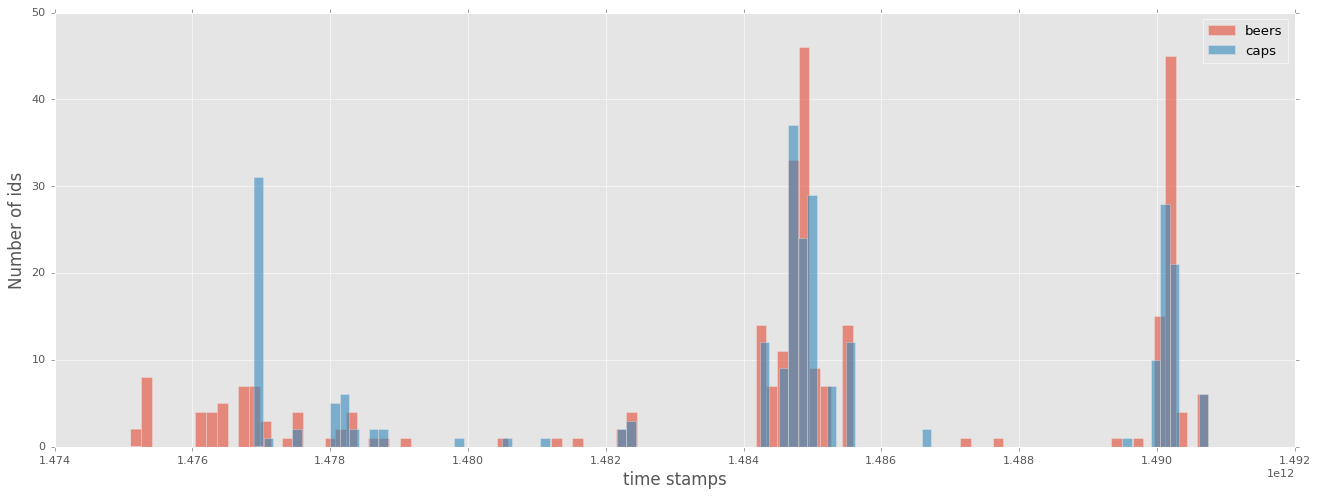

In [14]:
df_beers['first time stamp'].hist(bins=100,alpha=0.6,label='beers')
df_caps['first time stamp'].hist(bins=100,alpha=0.6,label='caps')
# df_sessions['first time stamp'].hist(bins=50,alpha=0.6,label='caps')
ax = plt.subplot()
ax.legend();ax.set_xlabel('time stamps',fontsize=15);ax.set_ylabel('Number of ids',fontsize=15)
# ax.set_xticks(range(int(min(df_beers['first time stamp'])),int(max(df_beers['first time stamp'])),100000000))
# ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)

In [18]:
print set(df_beers[df_beers['Session']=='NA']['studentid'])
print set(df_caps[df_caps['Session']=='NA']['studentid'])

set(['11111111', '12341234', '12345667', 'student1', '12345678', '12357888', '12344675', '12345567', '12344567', '78379161', '12344564'])
set([12456456, 78379161, 99999999, 12345678, 11111111])
